# DeepEnsemble modules

A notebook to walk through how to train and validate a Deep Ensemble model.

There are two options:
1) Run the source code using a command line argument.
2) Access the source code via individual modules.

After that we demonstrate:

3) Loading checkpoints
4) Making predictions for a test dataset
5) Predicting aleatoric uncertainty
6) Making loss plots

In [1]:
from analyze.analyze import AggregateCheckpoints
from models.models import model_setup_DE
from data.data import DataPreparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from train import train

In [14]:
# necessary in order to display matplotlib plots in a notebook environment
# when also running python scripts inline
%matplotlib inline

## 1. Command line argument
Here the dataset is generated on the fly using the `--generatedata` wildcard. The `save_data.ipynb` notebook generates how to train a model after first saving a dataframe.

In [61]:
noise = "low"
dim = "2D"
injection = "input"
n_models = 5
n_epochs = 100
data_size = "5000"
out_dir = "../DeepUQResources/"

In order to save all of the model checkpoints, the two flags `--save_all_checkpoints` and `--save_final_checkpoint` must be specified.

Reading settings from cli and default,               dumping to temp config:  ./DeepUQResources/temp/temp_config_DE_20241014122020.yml
generating the data
2D data
inject type is input, dim is 2D, sigma is 0.0003125
2D data generated,                 with noise injected type: input.
bins for uniformity in y [0.  0.2 0.4 0.6 0.8 1.  1.2 1.4 1.6 1.8 2. ]
starting n_bin_values [1276, 676, 471, 353, 307, 250, 235, 205, 180, 156]


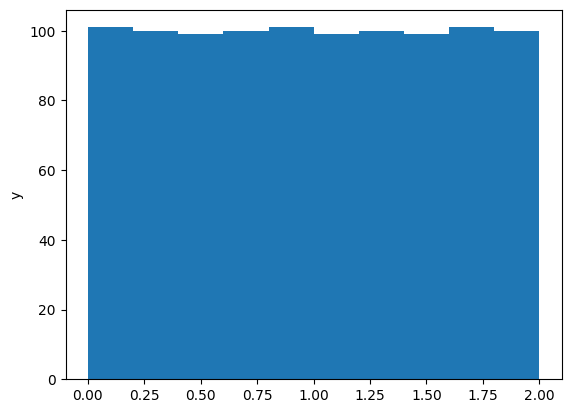

shape before cut (5000,)
shape once uniform (1000,)
size after uniform (1000, 32, 32)
shape of input (1000, 32, 32) shape of output (1000,)


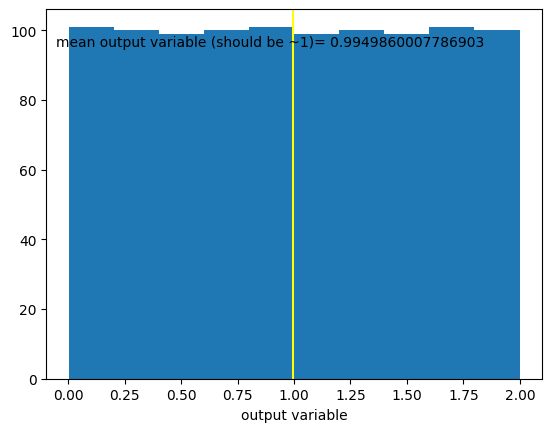

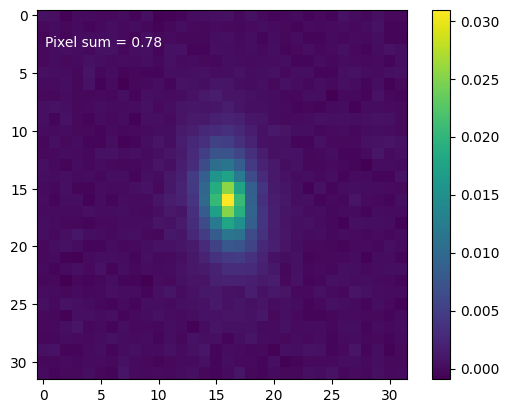

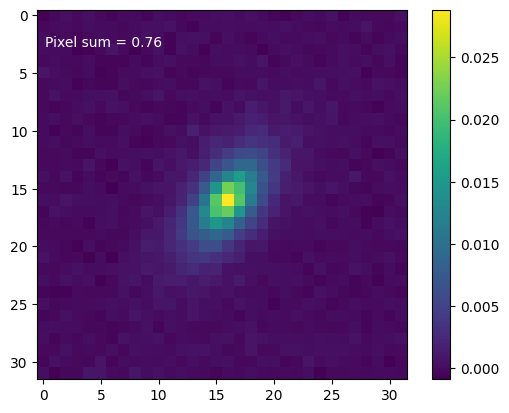

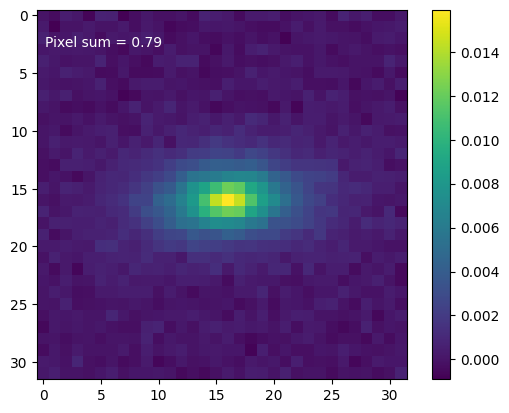

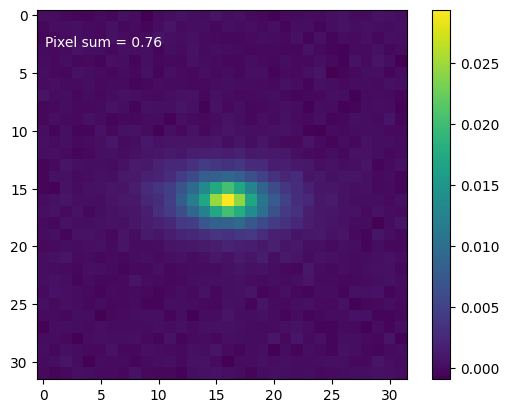

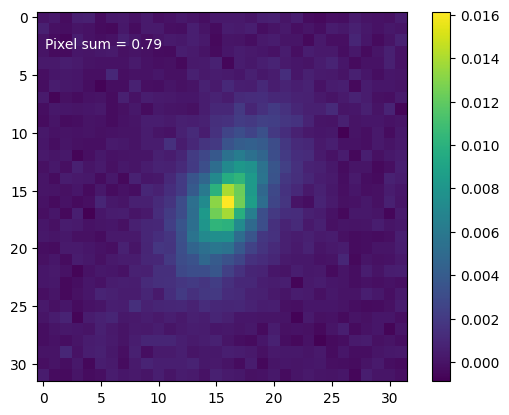

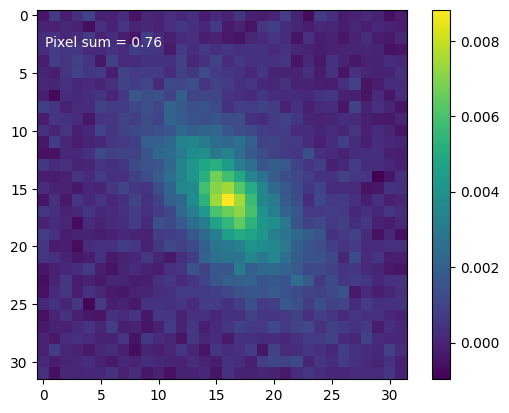

save final checkpoint has this value True
model name is  DE
dim is  2D
norm params None
starting here 0
model 0
model is Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (2): MuVarLayer()

<Figure size 640x480 with 0 Axes>

In [62]:
# %run is the same as !python
%run ../src/scripts/DeepEnsemble.py \
    --noise_level $noise \
    --n_models $n_models \
    --data_dimension $dim \
    --data_injection $injection \
    --out_dir $out_dir \
    --n_epochs $n_epochs \
    --generatedata \
    --uniform \
    --overwrite_final_checkpoint \
    --save_all_checkpoints \
    --save_final_checkpoint \
    --verbose


If you run via the command line, you can access the saved checkpoints. Let's do that for one of the models

## 2. Train via the modules
The other option is to use the data, model, and train modules and functions to separately prepare the data, set up the model, and train. This produces the same saved checkpoints as the script above.

In [34]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_type = 'bnll_loss'
model, lossFn = model_setup_DE(loss_type, DEVICE)

Below are keywords that get auto-defined in the cli implementation that must be specified in this approach to training the model.

In [35]:
norm = True
uniform = False
verbose = False
val_prop = 0.1
rs = 42
BATCH_SIZE = 100

In [37]:
data = DataPreparation()
model_inputs, model_outputs = data.generate_df(
            size_df, noise, dim, injection, uniform, verbose)
x_train, x_val, y_train, y_val = data.train_val_split(
    model_inputs,
    model_outputs,
    val_proportion=val_prop,
    random_state=rs,
)
trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(
    trainData, batch_size=BATCH_SIZE, shuffle=True
)

2D data
inject type is input, dim is 2D, sigma is 0.0015625
2D data generated,                 with noise injected type: input.


In [38]:
model_ensemble = train.train_DE(
        trainDataLoader,
        x_val,
        y_val,
        #config.get_item("model", "init_lr", "DE"),
        0.001,
        DEVICE,
        #config.get_item("model", "loss_type", "DE"),
        'bnll_loss',
        #config.get_item("model", "n_models", "DE"),
        5,
        norm_params,
        model_name='DE',
        BETA=0.5,
        EPOCHS=100,
        path_to_model=out_dir,
        inject_type=injection,
        data_dim=dim,
        noise_level=noise,
        save_all_checkpoints=True,
        save_final_checkpoint=True,
        overwrite_final_checkpoint=True,
        plot=False,
        savefig=False,
        set_and_save_rs=False,
    )

starting here 0
model 0
model is Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (2): MuVarLayer()
) lossfn <function loss_bnll at 0x10ee80af0>
epoch 0 0.0
new best loss 1.12169134616851

## 3. Loading checkpoints

Uncomment and run the below cell if you did not run the option 2 above (train via the modules).

In [ ]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
checkpoints = AggregateCheckpoints()

In [44]:
chk = checkpoints.load_checkpoint(
    "DE",
    injection,
    dim,
    noise,
    n_epochs - 1,
    DEVICE,
    path="../DeepUQResources/checkpoints/",
    nmodel=1
)

DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_1_epoch_99.pt


/Users/rnevin/Documents/DeepUQ/src/analyze/analyze.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(file_name, map_location=device)


The checkpoint contains a ton of useful information, including the training and validation MSE and $\beta-$NLL loss, and the weights and biases for the model that are required to re-run and the trained model on new data.

In [45]:
# set up the model and then load the checkpoint
DEmodel, lossFn = model_setup_DE(
    "bnll_loss", DEVICE, n_hidden=64, data_type=dim)

In [46]:
# define the model at this epoch
DEmodel.load_state_dict(chk.get("model_state_dict"))
# checkpoint['model_state_dict'])
DEmodel.eval()

Sequential(
  (0): ConvLayers(
    (conv1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv3): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (pool2): AvgPool2d(kernel_size=2, stride=2, padding=1)
    (conv4): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (1): Model(
    (model): Sequential(
      (0): Linear(in_features=360, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=2, bias=True)
    )
  )
  (2): MuVarLayer()
)

## 4. Make predictions for a test dataset

In [47]:
size_df = 10
data = DataPreparation()
x_test, y_test = data.generate_df(
            size_df, noise, dim, injection, uniform, verbose)

2D data
inject type is input, dim is 2D, sigma is 0.0015625
2D data generated,                 with noise injected type: input.


In [48]:
y_pred = DEmodel(
    torch.Tensor(x_test
        )
    ).detach().numpy()

[]

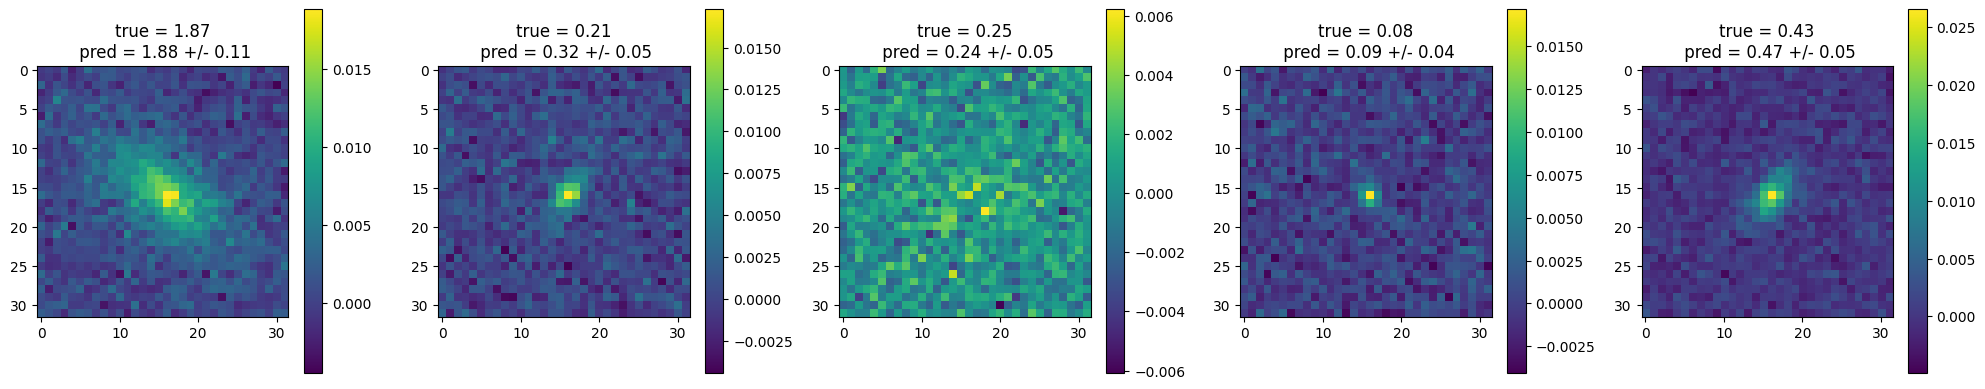

In [50]:
# Create a figure with 5 subplots in a horizontal row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Loop through each subplot
for i in range(5):
    
    ax = axes[i]
    ax.imshow(x_test[i, :, :], aspect='auto')
    ax.set_title(
        'true = '+str(round(y_test[i],2))+'\n pred = '
        +str(round(y_pred[i,0],2))+' +/- '+str(round(np.sqrt(y_pred[i,1]),2)))
    ax.figure.colorbar(ax.images[0], ax=ax)
    ax.set_aspect('equal')

# Show the complete figure
plt.tight_layout()
plt.plot()

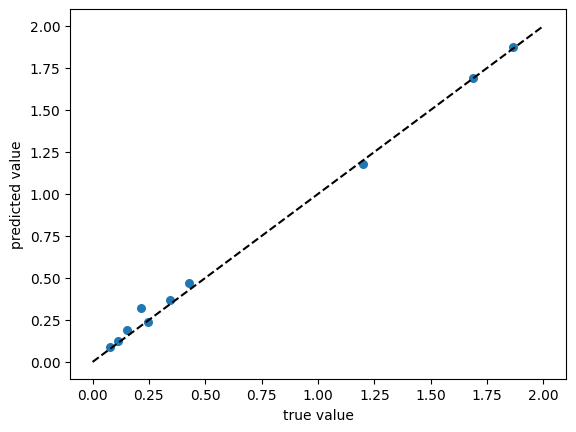

In [53]:
plt.scatter(
            y_test,
            y_pred[:, 0],
            #color=color_list[i],
            #label=r"$\sigma = $" + str(sigma_list[i]),
            s=30,
        )
plt.plot([0,2],[0,2], ls='--', color='black')
plt.xlabel('true value')
plt.ylabel('predicted value');

## 5. Predicting aleatoric uncertainty
Look at the output aleatoric uncertainty values, which are averaged over the entire test set and then averaged over all models in the ensemble.


In [56]:
u_al = []
for m in range(n_models):
    chk = checkpoints.load_checkpoint(
        "DE",
        injection,
        dim,
        noise,
        n_epochs - 1,
        DEVICE,
        path="../DeepUQResources/checkpoints/",
        nmodel=m
    )
    # define the model at this epoch
    DEmodel.load_state_dict(chk.get("model_state_dict"))
    # checkpoint['model_state_dict'])
    DEmodel.eval()
    y_pred = DEmodel(
        torch.Tensor(x_test
            )
        ).detach().numpy()
    
    u_al_one = np.sqrt(y_pred[:, 1])
    u_al.append(u_al_one)

DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_0_epoch_99.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_1_epoch_99.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_2_epoch_99.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_3_epoch_99.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_99.pt


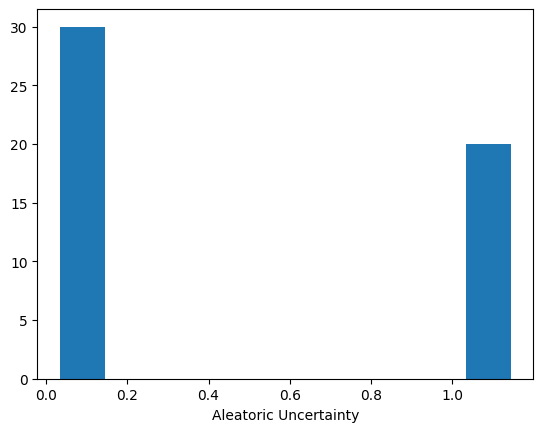

In [57]:
plt.hist(np.concatenate(u_al))
plt.xlabel('Aleatoric Uncertainty')
plt.show()

## 6. Loss plots
Let's also plot the loss history for these models.

In [59]:
train_loss = []
train_mse = []
valid_loss = []
valid_mse = []
for e in range(n_epochs):
    chk = checkpoints.load_checkpoint(
        "DE",
        injection,
        dim,
        noise,
        e,
        DEVICE,
        path="../DeepUQResources/checkpoints/",
        nmodel=m
    )
    train_loss.append(chk['train_loss'])
    train_mse.append(chk['train_mse'])
    valid_loss.append(chk['valid_loss'])
    valid_mse.append(chk['valid_mse'])

DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_0.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_1.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_2.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_3.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_4.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_5.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_6.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_7.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_input_2D_noise_medium_beta_0.5_nmodel_4_epoch_8.pt
DE
loading this chk ../DeepUQResources/checkpoints/DE_i

<Figure size 640x480 with 0 Axes>

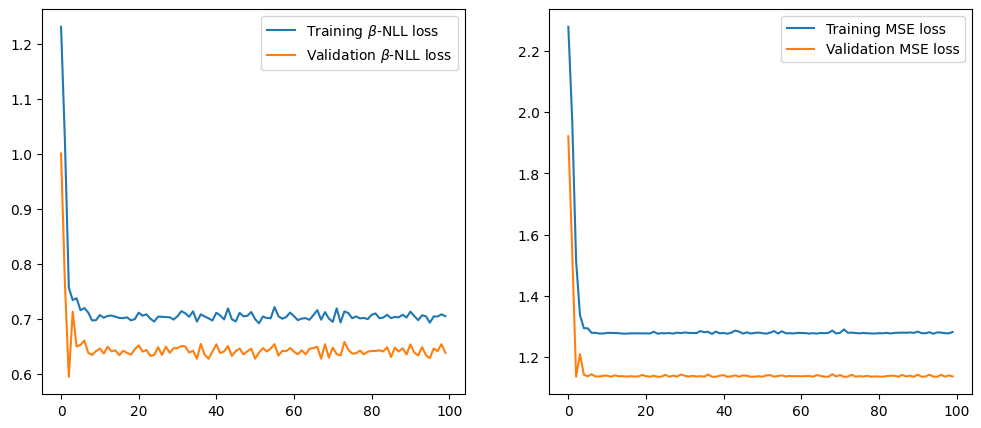

In [60]:
plt.clf()
fig = plt.figure(figsize=(12,5))
ax0 = fig.add_subplot(121)
ax0.plot(range(n_epochs), train_loss, label=r'Training $\beta$-NLL loss')
ax0.plot(range(n_epochs), valid_loss, label=r'Validation $\beta$-NLL loss')
ax0.legend()

ax1 = fig.add_subplot(122)
ax1.plot(range(n_epochs), train_mse, label='Training MSE loss')
ax1.plot(range(n_epochs), valid_mse, label='Validation MSE loss')
ax1.legend()
plt.show()